# Notebook 8 — Advanced Math Topics for AI

This capstone notebook covers key mathematical tools often used in modern ML/AI:
1) Information theory (entropy, cross-entropy, KL),
2) Vector & matrix calculus (gradient, Jacobian, Hessian),
3) Multivariate probability (MVN),
4) Manifolds & geometry (intuitions),
5) Fourier transforms (signal view for ML),
6) Tensors in DL,
7) Capstone exercises (KL, MVN PDF, PCA from scratch).

Run sequentially. Exercises are marked with **TODO**.

## 1. Information Theory Essentials

**Entropy** (discrete):  \(H(P) = -\sum_i p_i \log p_i\)

**Cross-Entropy**:  \(H(P, Q) = -\sum_i p_i \log q_i\)

    
**KL Divergence**:  \(\mathrm{KL}(P\parallel Q) = \sum_i p_i\log \frac{p_i}{q_i} = H(P, Q) - H(P)\)

Notes:
- Base of log sets units (bits if base 2, nats if natural log). We’ll use natural log.
- KL is **asymmetric** and **non-negative** (Gibbs’ inequality).
- In classification, minimizing cross-entropy between empirical label distribution and predicted distribution is equivalent to maximizing likelihood.

In [1]:
import numpy as np

def entropy(p):
    p = np.asarray(p, dtype=float)
    p = p / p.sum()
    p = np.clip(p, 1e-12, 1)  # avoid log(0)
    return -np.sum(p * np.log(p))

def cross_entropy(p, q):
    p = np.asarray(p, dtype=float); p = p / p.sum()
    q = np.asarray(q, dtype=float); q = q / q.sum()
    q = np.clip(q, 1e-12, 1)
    return -np.sum(p * np.log(q))

def kl_divergence(p, q):
    p = np.asarray(p, dtype=float); p = p / p.sum()
    q = np.asarray(q, dtype=float); q = q / q.sum()
    p = np.clip(p, 1e-12, 1); q = np.clip(q, 1e-12, 1)
    return np.sum(p * (np.log(p) - np.log(q)))

P = np.array([0.7, 0.2, 0.1])
Q = np.array([0.6, 0.25, 0.15])
print('H(P)=', entropy(P))
print('H(P,Q)=', cross_entropy(P, Q))
print('KL(P||Q)=', kl_divergence(P, Q))
print('Check H(P,Q)-H(P)=', cross_entropy(P,Q)-entropy(P))

H(P)= 0.8018185525433373
H(P,Q)= 0.8245488073487599
KL(P||Q)= 0.02273025480542254
Check H(P,Q)-H(P)= 0.022730254805422567


**Exercise 1 — Label smoothing & CE:**
Given a one-hot label distribution `y=[0,0,1,0]` and prediction `p=[0.01, 0.02, 0.95, 0.02]`:
1) Compute cross-entropy.  
2) Apply label smoothing with ε=0.1 (i.e., target = (1-ε)*one_hot + ε/K) and recompute CE.  
3) Comment on the effect of smoothing.


In [2]:
# TODO Exercise 1
y = np.array([0,0,1,0], dtype=float)
p = np.array([0.01, 0.02, 0.95, 0.02], dtype=float)

# 1) CE(y, p)

# 2) Label smoothing ε=0.1

# 3) Comment in markdown after computing values


## 2. Vector & Matrix Calculus: Gradients, Jacobians, Hessians

- **Gradient** of scalar f(x) ∈ ℝ with x∈ℝ^n is ∇f ∈ ℝ^n.
- **Jacobian** of vector function g(x)∈ℝ^m is J_ij = ∂g_i/∂x_j (matrix m×n).
- **Hessian** of scalar f is H_ij = ∂²f/(∂x_i∂x_j) (matrix n×n).

Example:  
Let \(f(x) = \tfrac{1}{2} x^\top A x + b^\top x + c\). Then
\(\nabla f(x) = A x + b\) (if A is symmetric), and Hessian H = A.

We’ll verify gradient numerically via finite differences.

In [3]:
def quad_f(x, A, b, c=0.0):
    x = x.reshape(-1,1)
    return 0.5 * float(x.T @ A @ x) + float(b.T @ x) + c

def grad_quad(x, A, b):
    return (A @ x + b).ravel()

def numerical_grad(f, x, eps=1e-6):
    x = x.astype(float)
    g = np.zeros_like(x)
    for i in range(len(x)):
        x1 = x.copy(); x1[i] += eps
        x2 = x.copy(); x2[i] -= eps
        g[i] = (f(x1) - f(x2)) / (2*eps)
    return g

np.random.seed(0)
n = 5
A = np.random.randn(n, n)
A = 0.5*(A + A.T) + n*np.eye(n)  # symmetric PD for stability
b = np.random.randn(n)
x0 = np.random.randn(n)

f = lambda z: quad_f(z, A, b, 0.0)
g_true = grad_quad(x0, A, b)
g_num = numerical_grad(f, x0)
print('||g_true - g_num|| =', np.linalg.norm(g_true - g_num))
print('Hessian ~ A (symmetric): eigenvalues min/max =', np.linalg.eigvalsh(A)[0], np.linalg.eigvalsh(A)[-1])

||g_true - g_num|| = 1.6975865532810496e-09
Hessian ~ A (symmetric): eigenvalues min/max = 3.9760118299568865 8.180345674920751


/var/folders/4t/hxwpb0yj2llgt8c1gv_r6dv40000gn/T/ipykernel_10900/932283176.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return 0.5 * float(x.T @ A @ x) + float(b.T @ x) + c


**Exercise 2 — Logistic regression gradient:**
For a single datapoint (x, y) with y∈{0,1} and model \(\hat{y}=\sigma(w^\top x)\), loss L = −[ y log(ŷ) + (1−y) log(1−ŷ) ].  
1) Derive \(\nabla_w L = (\hat{y} - y) x\).  
2) Implement a function that computes this gradient for a mini-batch X∈ℝ^{N×d}, y∈{0,1}^N.
3) Verify against numerical gradient checking (like above).

In [4]:
# TODO Exercise 2 — implement logistic gradient and gradient check
def sigmoid(z):
    return 1/(1+np.exp(-z))

def logloss_and_grad(w, X, y):
    # TODO: return loss, grad for batch
    raise NotImplementedError

def numerical_grad_generic(f, w, eps=1e-6):
    g = np.zeros_like(w)
    for i in range(len(w)):
        w1 = w.copy(); w1[i] += eps
        w2 = w.copy(); w2[i] -= eps
        g[i] = (f(w1) - f(w2)) / (2*eps)
    return g

# Create small random problem and check ||g - g_num||


## 3. Multivariate Probability — Multivariate Gaussian (MVN)

MVN: \(x \sim \mathcal{N}(\mu, \Sigma)\) with density
\[ p(x) = \frac{1}{\sqrt{(2\pi)^k |\Sigma|}} \exp\Big(-\tfrac{1}{2}(x-\mu)^\top \Sigma^{-1}(x-\mu)\Big). \]

Key facts:
- \(\Sigma\) must be positive semidefinite; invertibility requires PD.
- Affine transforms of MVN remain Gaussian.
- Marginals and conditionals of a joint Gaussian are Gaussian.

We’ll implement the MVN PDF and sample from it, then compare sample mean/cov to ground truth.

In [5]:
def mvn_pdf(x, mu, Sigma):
    x = np.atleast_2d(x)
    k = mu.size
    Sigma = np.asarray(Sigma)
    L = np.linalg.cholesky(Sigma)
    # Solve for z in L z = (x-mu)
    diff = (x - mu)
    sol = np.linalg.solve(L, diff.T)
    quad = np.sum(sol**2, axis=0)
    log_det = 2*np.sum(np.log(np.diag(L)))
    log_norm = -0.5*(k*np.log(2*np.pi) + log_det)
    log_pdf = log_norm - 0.5*quad
    return np.exp(log_pdf).ravel()

np.random.seed(42)
mu = np.array([1.0, -2.0])
Sigma = np.array([[2.0, 0.8],[0.8, 1.5]])
samples = np.random.multivariate_normal(mu, Sigma, size=10_000)
print('sample mean ~', samples.mean(axis=0))
print('sample cov  ~\n', np.cov(samples.T))
print('pdf at mu   ~', mvn_pdf(mu, mu, Sigma))
print('pdf at mu+1 ~', mvn_pdf(mu+1.0, mu, Sigma))

sample mean ~ [ 0.99092731 -1.99742085]
sample cov  ~
 [[2.02878086 0.83520555]
 [0.83520555 1.51728399]]
pdf at mu   ~ [0.10360104]
pdf at mu+1 ~ [0.06926952]


**Exercise 3 — Conditional Gaussian:**
Partition a 2D Gaussian into X=(X₁, X₂). Show that \(X_1 | X_2=x_2\) is Gaussian with
\(\mu_{1|2} = \mu_1 + \Sigma_{12} \Sigma_{22}^{-1}(x_2 - \mu_2)\) and 
\(\Sigma_{1|2} = \Sigma_{11} - \Sigma_{12}\Sigma_{22}^{-1}\Sigma_{21}\).  
1) Write a function to compute conditional mean/cov given a joint (μ, Σ) and observed x₂.  
2) Validate by simulation: draw many samples, filter those with X₂≈x₂ (within small band), compare their empirical mean to \(\mu_{1|2}\).

In [6]:
# TODO Exercise 3 — implement conditional Gaussian helpers
def gaussian_conditional(mu, Sigma, x2):
    # mu: (2,), Sigma: (2,2), x2: scalar
    raise NotImplementedError

# Validate by simulation (hint: use rejection or small band around x2)


## 4. Manifolds & Geometry — Intuitions for ML

- Many datasets lie on **low-dimensional manifolds** embedded in high-dimensional space (e.g., images of the same object under rotation).
- **Tangent space** at a point approximates the manifold locally (linearization). This underpins methods like locally linear embedding and also justifies small-step gradient methods.
- **Geodesic distances** (shortest path on manifold) can differ from Euclidean; Isomap approximates geodesics with graph shortest paths.

We’ll visualize a Swiss roll and compare Euclidean vs graph (geodesic-like) distances qualitatively.

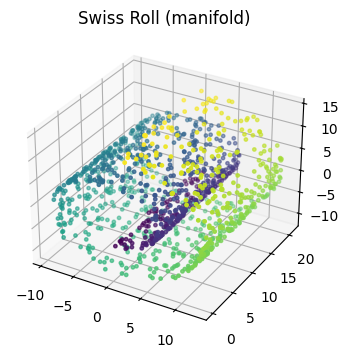

Graph nonzeros ~ 9600
This sparse graph approximates local manifold connectivity.


In [7]:
import numpy as np
import matplotlib.pyplot as plt

def swiss_roll(n=1000, noise=0.0, seed=0):
    rng = np.random.default_rng(seed)
    t = 1.5 * np.pi * (1 + 2 * rng.random(n))
    x = t * np.cos(t)
    y = 21 * rng.random(n)
    z = t * np.sin(t)
    X = np.vstack((x, y, z)).T
    if noise > 0:
        X += noise * rng.standard_normal(X.shape)
    return X, t

X, t = swiss_roll(1200, noise=0.05)
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(X[:,0], X[:,1], X[:,2], c=t, s=6)
ax.set_title('Swiss Roll (manifold)'); plt.show()

# Simple kNN graph to hint geodesic paths (no full Isomap to keep deps minimal)
from sklearn.neighbors import kneighbors_graph
G = kneighbors_graph(X, n_neighbors=8, mode='distance')
print('Graph nonzeros ~', G.nnz)
print('This sparse graph approximates local manifold connectivity.')

**Exercise 4 — Manifold distances:**
1) Pick two points on the roll far apart in Euclidean distance but close on the manifold (or vice versa).  
2) Compute shortest path on the kNN graph (e.g., with `scipy.sparse.csgraph.shortest_path` if available) and compare to Euclidean distance.  
3) Briefly discuss why manifold-aware methods can preserve neighborhood structure better for such data.

In [8]:
# TODO Exercise 4 — compute graph shortest paths vs Euclidean for selected pairs
pair_idx = (0, 500)  # feel free to change
i, j = pair_idx

euclid = np.linalg.norm(X[i]-X[j])
print('Euclidean distance:', euclid)

try:
    from scipy.sparse.csgraph import shortest_path
    dist_mat = shortest_path(G, directed=False)
    print('Graph shortest-path distance:', dist_mat[i, j])
except Exception as e:
    print('Install SciPy to compute graph geodesics. Error:', e)

# Add markdown comments after running to reflect observations


Euclidean distance: 10.033908716609455
Graph shortest-path distance: 45.51589620219005


## 5. Fourier Transform — Signal View for ML

- **Fourier Transform (FT)** decomposes signals into frequencies; useful in image denoising, audio features, and some neural operators.
- **Discrete FT (DFT)** via FFT in NumPy (`np.fft.fft`, `np.fft.fft2`).

Demo: smooth vs noisy 1D signal; denoise by zeroing small high-frequency components (simple spectral filtering).

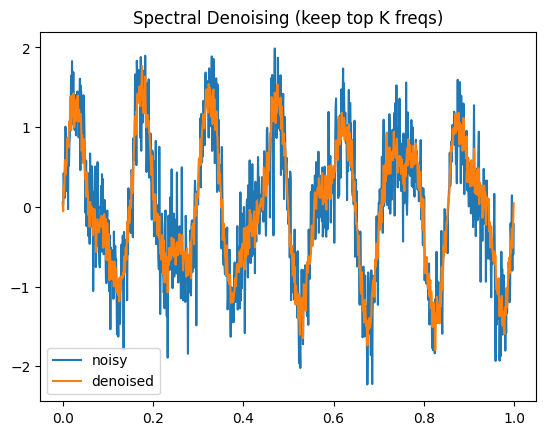

In [9]:
import numpy as np, matplotlib.pyplot as plt
rng = np.random.default_rng(0)
n = 1024
x = np.linspace(0, 1, n, endpoint=False)
signal = np.sin(2*np.pi*7*x) + 0.5*np.sin(2*np.pi*13*x)
noisy = signal + 0.4*rng.standard_normal(n)

F = np.fft.fft(noisy)
mag = np.abs(F)

# Keep top K frequencies by magnitude
K = 30
idx = np.argsort(mag)[-K:]
F_filt = np.zeros_like(F)
F_filt[idx] = F[idx]
denoised = np.fft.ifft(F_filt).real

plt.figure(); plt.plot(x, noisy, label='noisy'); plt.plot(x, denoised, label='denoised'); plt.legend(); plt.title('Spectral Denoising (keep top K freqs)'); plt.show()

**Exercise 5 — 2D FFT (images):**
1) Create a synthetic 2D image with a checkerboard pattern + noise.  
2) Use `np.fft.fft2` and `fftshift` to visualize spectrum magnitude.  
3) Apply a low-pass filter (zero out high-frequency components) and reconstruct with `ifft2`.  
4) Comment on artifacts and the filter shape (circular vs square mask).

In [10]:
# TODO Exercise 5 — 2D FFT on synthetic image
import numpy as np
import matplotlib.pyplot as plt

n = 256
x = np.arange(n)
y = np.arange(n)
X, Y = np.meshgrid(x, y)
checker = ((X//16 + Y//16) % 2).astype(float)
rng = np.random.default_rng(1)
img = checker + 0.3*rng.standard_normal((n, n))

# 1) visualize img
# 2) FFT2, shift, visualize spectrum magnitude (log)
# 3) Low-pass mask and reconstruct


## 6. Tensors & Tensor Calculus — Deep Learning View

- **Tensor**: multi-dimensional array (rank = number of axes). Vectors rank-1, matrices rank-2, images rank-3 (H×W×C), batches rank-4 (N×H×W×C).
- Common ops: reshape, transpose/permute, broadcasting, tensordot/einsum.
- Many DL operations can be expressed via `einsum` for clarity.

We’ll show: (1) broadcasting pitfalls, (2) einsum examples (matrix multiply, batched matmul, attention-like score).

In [11]:
import numpy as np

# Broadcasting demo: add bias to batch of features
X = np.random.randn(4, 3)  # batch=4, features=3
b = np.random.randn(3)     # feature bias
Y = X + b  # broadcasts over batch
print('Y.shape=', Y.shape)

# Einsum examples
A = np.random.randn(5, 7)
B = np.random.randn(7, 6)
C1 = A @ B
C2 = np.einsum('ij,jk->ik', A, B)
print('Matmul diff ||C1-C2|| =', np.linalg.norm(C1-C2))

# Batched matmul: (batch, i, j) x (batch, j, k) -> (batch, i, k)
A_b = np.random.randn(10, 5, 7)
B_b = np.random.randn(10, 7, 6)
C_b = np.einsum('bij,bjk->bik', A_b, B_b)
print('Batched result shape:', C_b.shape)

# Attention-like score: scores = Q K^T / sqrt(d)
d = 64
Q = np.random.randn(8, d)  # 8 queries
K = np.random.randn(12, d) # 12 keys
scores = np.einsum('qd,kd->qk', Q, K) / np.sqrt(d)
print('scores shape:', scores.shape)

Y.shape= (4, 3)
Matmul diff ||C1-C2|| = 3.0499892170931996e-15
Batched result shape: (10, 5, 6)
scores shape: (8, 12)


**Exercise 6 — Stable softmax & log-sum-exp:**
1) Implement a numerically stable softmax and verify rows sum to ~1 for large inputs.  
2) Implement stable log-sum-exp for a vector and compare to naive `np.log(np.sum(np.exp(x)))` on large values.  
3) Briefly explain why subtracting `x.max()` stabilizes the computation.

In [12]:
# TODO Exercise 6 — stable softmax and LSE
def softmax_stable(X, axis=-1):
    # hint: subtract max along axis, then exp, then normalize
    raise NotImplementedError

def logsumexp_stable(x):
    # hint: m = max(x); return m + log(sum(exp(x-m)))
    raise NotImplementedError

# Test on big values
big = np.array([1000.0, 999.0, 998.0])
print('Naive LSE may overflow; implement stable version!')


Naive LSE may overflow; implement stable version!


## 7. Capstone Exercises

**Exercise 7.1 — KL divergence (continuous, Gaussians):**  
For \(\mathcal{N}(\mu_0,\sigma_0^2)\) and \(\mathcal{N}(\mu_1,\sigma_1^2)\),
\[ \mathrm{KL}(0\parallel 1) = \log\frac{\sigma_1}{\sigma_0} + \frac{\sigma_0^2 + (\mu_0-\mu_1)^2}{2\sigma_1^2} - \frac{1}{2}. \]
1) Implement a function `kl_gaussians(mu0, s0, mu1, s1)` using this closed form.  
2) Validate numerically by Monte Carlo estimation of KL via samples from dist 0:  \(\mathbb{E}_{x\sim 0}[\log p_0(x) - \log p_1(x)]\).

**Exercise 7.2 — MVN PDF (general k):**  
Generalize the earlier `mvn_pdf` to handle broadcasting over multiple `x` and return vector of densities.

**Exercise 7.3 — PCA from scratch:**  
1) Center data X (N×d), compute covariance \(\hat{\Sigma} = \frac{1}{N-1} X_c^\top X_c\).  
2) Eigendecompose Σ; sort eigenpairs; project onto top-k.  
3) Compare to `sklearn.decomposition.PCA` on a synthetic dataset (e.g., 2D data stretched in one direction + noise).  
4) Plot original data and PCA reconstruction for k=1.


In [13]:
# TODO Exercise 7.1 — KL for 1D Gaussians + Monte Carlo check
import numpy as np
from math import log, sqrt, pi

def kl_gaussians(mu0, s0, mu1, s1):
    # s0,s1 are std devs (>0)
    raise NotImplementedError

def log_normal_pdf(x, mu, s):
    return -0.5*np.log(2*np.pi*s**2) - 0.5*((x-mu)/s)**2

# Monte Carlo check
mu0, s0 = 0.0, 1.0
mu1, s1 = 1.0, 2.0
rng = np.random.default_rng(0)
x = rng.normal(mu0, s0, size=200_000)
kl_mc = np.mean(log_normal_pdf(x, mu0, s0) - log_normal_pdf(x, mu1, s1))
print('KL MC ~', kl_mc)

# TODO: print closed-form KL and compare


KL MC ~ 0.44221401373875413


In [14]:
# TODO Exercise 7.2 — generalized MVN PDF with broadcasting
def mvn_pdf_broadcast(X, mu, Sigma):
    # Support X shape (N,k) or (k,), mu (k,), Sigma (k,k)
    raise NotImplementedError

# Quick test with random points


In [15]:
# TODO Exercise 7.3 — PCA from scratch + comparison with sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

rng = np.random.default_rng(42)
N = 400
theta = np.deg2rad(20)
R = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])
base = rng.normal(0, 1, size=(N, 2)) @ np.diag([3.0, 0.5]) @ R.T + np.array([5, -2])

# 1) Center, cov, eig
# 2) Sort eigenpairs, project to k=1, reconstruct
# 3) Compare to sklearn PCA
# 4) Plot original + reconstruction


## Wrap-up
- Information theory connects directly to ML losses (cross-entropy) and divergences (KL, JS).
- Matrix calculus underpins optimization and backprop; gradient checks are invaluable.
- MVN fundamentals are used in probabilistic modeling, Kalman filters, VAEs.
- Manifold insights explain why nonlinear dimensionality reduction works.
- Fourier methods often appear in signal/image tasks and in modern operator networks.
- Tensors/einsum thinking makes complex DL ops succinct and stable.

With this, **Section 1: Applied Mathematics for ML/AI** is complete. Next up: **Section 2 — Core Machine Learning Algorithms**.